In [7]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import gaussian_kde
from scipy.ndimage import uniform_filter1d
from concurrent.futures import ProcessPoolExecutor, as_completed
import os
import string
from tqdm import tqdm
import pickle
from scipy.stats import binom
from IPython.display import display
from scipy.special import gammaln
import gc

In [8]:
# Building or restoring cache

# Cache log(n!) values
# gammaln(n+1) = ln(n!)
# Lower bound must be 1
try:
    log_n_factorial = np.load("log_n_factorial.npy")
except FileNotFoundError:
    log_n_factorial = gammaln(np.arange(1, 3200000+2, dtype=np.float64))
    np.save("log_n_factorial.npy", log_n_factorial)

# Cache s_2 values where s=size of cluster/node
# s_2[node][s] will return s^2 value for a system size 'node'
try:
    with open("s_2.pkl", 'rb') as f:
        s_2 = pickle.load(f)
except FileNotFoundError:
    s_2 = {}
    all_nodes = [100000, 200000, 400000, 800000, 1600000, 3200000]
    for node in all_nodes:
        s = np.arange(node+1, dtype=np.float64)
        s = s/node
        s = np.power(s, 2)
        s_2[node] = s
    with open("s_2.pkl", 'wb') as f:
        pickle.dump(s_2, f)
        
# Cache s_4 values where s=size of cluster/node
# s_4[node][s] will return s^4 value for a system size 'node'
try:
    with open("s_4.pkl", 'rb') as f:
        s_4 = pickle.load(f)
except FileNotFoundError:
    s_4 = {}
    all_nodes = [100000, 200000, 400000, 800000, 1600000, 3200000]
    for node in all_nodes:
        s = np.arange(node+1, dtype=np.float64)
        s = s/node
        s = np.power(s, 4)
        s_4[node] = s
    with open("s_4.pkl", 'wb') as f:
        pickle.dump(s_4, f)

########## Uncomment if you want Shannon Entopy ########
        
# Cache s*log(s) values where s is the size of a cluster / node) 
# s_log_s[node][s] will return s*log(s) value for a system size 'node'
# For this case entropy change for merging two clusters of size s_i and s_j will be calculated as follows
# del_s = (s_i*log(s_i) + s_j*log(s_j) - (s_i+s_j)*log(s_i+s_j))
# try:
#     with open("s_log_s.pkl", 'rb') as f:
#         s_log_s = pickle.load(f)
# except FileNotFoundError:
#     s_log_s = {}
#     all_nodes = [100000, 200000, 400000, 800000, 1600000, 3200000]
#     for node in all_nodes:
#         s = np.arange(node+1, dtype=np.float64)
#         s = s/node
#         # Set s[0] value 1 to avoid warning since log(0) is undefined, we will not use this value anyway
#         s[0] = 1
#         s = s*np.log(s)
#         s_log_s[node] = s
#     with open("s_log_s.pkl", 'wb') as f:
#         pickle.dump(s_log_s, f)

In [9]:
def explosive_percolation_me1(num_of_nodes):
    # s_4, s_2 and s_log_s cache for the system
    global s_4_cache
    global s_2_cache
    # global s_log_s_cache
    
    # Necessary lists for percolation
    cluster_ids = np.arange(0, num_of_nodes)
    cluster_size = np.ones(num_of_nodes, dtype=np.int64) # Here Size means number of sites

    # A dictionary for members of a cluster
    # and a list of sets for directly connected nodes for each node
    cluster_members = {}
    for ids in cluster_ids:
        cluster_members[ids] = set([ids])
    connected_ids = [set([ids]) for ids in cluster_ids]

    # Output data
    # For convinience, we are taking one extra value. This will act as initial.
    # The function will return value from idx 1 to last
    # We will mainly calculate Boltzmann Entropy
    entropy = np.zeros(num_of_nodes+1, dtype=np.float64)
    entropy[0] = log_n_factorial[num_of_nodes]
    # # Shanon Entropy will be calculated for test purpose
    # entropy_shanon = np.zeros(num_of_nodes+1, dtype=np.float64)
    # entropy_shanon[0] = -s_log_s_cache[1]*num_of_nodes
    # Largest cluster size at each step
    largest_cluster_size = np.ones(num_of_nodes+1, dtype=np.int32)
    # Sum of s_i^4 at each step where s_i = size of a cluster / total size
    sum_s_4 = np.zeros(num_of_nodes+1, dtype=np.float64)
    sum_s_4[0] = s_4_cache[1]*num_of_nodes
    # Sum of s_i^2 at each step where s_i = size of a cluster / total size
    sum_s_2 = np.zeros(num_of_nodes+1, dtype=np.float64)
    sum_s_2[0] = s_2_cache[1]*num_of_nodes
    

    # Create two copies of list of nodes idx and shuffle them
    # Use the shuffled items as node 1 and node 3
    node_1s = cluster_ids.copy()
    node_1s = random.choices(node_1s, k=num_of_nodes)
    node_3s = cluster_ids.copy()
    node_3s = random.choices(node_3s, k=num_of_nodes)

    # # Test to check if shanon and boltzmann disagree
    # count = 0

    for n, node_1, node_3 in zip(range(num_of_nodes), node_1s, node_3s):
        # Randomly select 2nd node but make sure it doesn't select any node directly connected to node 1
        node_2 = random.randint(0, num_of_nodes-1)
        while node_2 in connected_ids[node_1]:
            node_2 = random.randint(0, num_of_nodes-1)

        # Randomly select 4th node but make sure it doesn't select any node directly connected to node 3
        node_4 = random.randint(0, num_of_nodes-1)
        while node_4 in connected_ids[node_3] or node_4 == node_2:
            node_4 = random.randint(0, num_of_nodes-1)

        # Get the cluster ids
        cluster_1 = cluster_ids[node_1]
        cluster_2 = cluster_ids[node_2]
        cluster_3 = cluster_ids[node_3]
        cluster_4 = cluster_ids[node_4]

        # Get the cluster sizes
        cluster_1_size = cluster_size[cluster_1]
        cluster_2_size = cluster_size[cluster_2]
        cluster_3_size = cluster_size[cluster_3]
        cluster_4_size = cluster_size[cluster_4]

        # If any bond is intra-cluster, add these two bonds
        # Check if the bonds are intra-cluster
        is_12_intra = cluster_1 == cluster_2
        is_34_intra = cluster_3 == cluster_4

        # If both bonds are intra-cluster, add the minimum sized cluster bonds
        if is_12_intra and is_34_intra:
            # Add the intra link of the smaller cluster
            if cluster_1_size < cluster_3_size:
                # Update directly connected id list
                connected_ids[node_1].add(node_2)
                connected_ids[node_2].add(node_1)
                # Update Entropy
                entropy[n+1] = entropy[n]
                # # Update Shanon Entropy
                # entropy_shanon[n+1] = entropy_shanon[n]
                # Update largest cluster
                largest_cluster_size[n+1] = largest_cluster_size[n]
                # Update s^4
                sum_s_4[n+1] = sum_s_4[n]
                # Update s^2
                sum_s_2[n+1] = sum_s_2[n]
            else:
                # Update directly connected id list
                connected_ids[node_3].add(node_4)
                connected_ids[node_4].add(node_3)
                # Update Entropy
                entropy[n+1] = entropy[n]
                # # Update Shanon Entropy
                # entropy_shanon[n+1] = entropy_shanon[n]
                # Update largest cluster
                largest_cluster_size[n+1] = largest_cluster_size[n]
                # Update s^4
                sum_s_4[n+1] = sum_s_4[n]
                # Update s^2
                sum_s_2[n+1] = sum_s_2[n]

            continue

        # If any one bond is intra-cluster, add the bond
        if is_12_intra:
            # Update directly connected id list
            connected_ids[node_1].add(node_2)
            connected_ids[node_2].add(node_1)
            # Update Entropy
            entropy[n+1] = entropy[n]
            # # Update Shanon Entropy
            # entropy_shanon[n+1] = entropy_shanon[n]
            # Update largest cluster
            largest_cluster_size[n+1] = largest_cluster_size[n]
            # Update s^4
            sum_s_4[n+1] = sum_s_4[n]
            # Update s^2
            sum_s_2[n+1] = sum_s_2[n]

            continue

        if is_34_intra:
            # Update directly connected id list
            connected_ids[node_3].add(node_4)
            connected_ids[node_4].add(node_3)
            # Update Entropy
            entropy[n+1] = entropy[n]
            # # Update Shanon Entropy
            # entropy_shanon[n+1] = entropy_shanon[n]
            # Update largest cluster
            largest_cluster_size[n+1] = largest_cluster_size[n]
            # Update s^4
            sum_s_4[n+1] = sum_s_4[n]
            # Update s^2
            sum_s_2[n+1] = sum_s_2[n]

            continue

        # Comparing Entropies
        del_s_12 = abs(log_n_factorial[cluster_1_size] + log_n_factorial[cluster_2_size] - log_n_factorial[cluster_1_size+cluster_2_size])
        del_s_34 = abs(log_n_factorial[cluster_3_size] + log_n_factorial[cluster_4_size] - log_n_factorial[cluster_3_size+cluster_4_size])

        # # Comparing shanon entropies
        # del_s_12_shanon = abs(s_log_s_cache[cluster_1_size] + s_log_s_cache[cluster_2_size] - s_log_s_cache[cluster_1_size+cluster_2_size])
        # del_s_34_shanon = abs(s_log_s_cache[cluster_3_size] + s_log_s_cache[cluster_4_size] - s_log_s_cache[cluster_3_size+cluster_4_size])

        # # Check if shanon and boltzmann disagree for small N
        # if (del_s_12 < del_s_34) != (del_s_12_shanon < del_s_34_shanon):
        #     count += 1

        # If del_s_12 is less than del_s_34, add the link between 1 and 2 and update the parameters
        if del_s_12 < del_s_34:
            entropy_change = del_s_12
            # shanon_entropy_change = del_s_12_shanon
            # Select the larger cluster as parent
            if cluster_2_size < cluster_1_size:
                parent_id = node_1
                parent_cluster_size = cluster_1_size
                parent_cluster_id = cluster_1
                child_id = node_2
                child_cluster_size = cluster_2_size
                child_cluster_id = cluster_2
            else:
                parent_id = node_2
                parent_cluster_size = cluster_2_size
                parent_cluster_id = cluster_2
                child_id = node_1
                child_cluster_size = cluster_1_size
                child_cluster_id = cluster_1

        else:
            entropy_change = del_s_34
            # shanon_entropy_change = del_s_34_shanon
            # Select the larger cluster as parent
            if cluster_4_size < cluster_3_size:
                parent_id = node_3
                parent_cluster_size = cluster_3_size
                parent_cluster_id = cluster_3
                child_id = node_4
                child_cluster_size = cluster_4_size
                child_cluster_id = cluster_4
            else:
                parent_id = node_4
                parent_cluster_size = cluster_4_size
                parent_cluster_id = cluster_4
                child_id = node_3
                child_cluster_size = cluster_3_size
                child_cluster_id = cluster_3

        # Update cluster_size
        cluster_size[parent_cluster_id] = parent_cluster_size + child_cluster_size
        # Reset the child cluster size to zero indicating it doesn't exists
        cluster_size[child_cluster_id] = 0

        # For all sites of the child cluster, update their cluster id as the parent cluster id
        child_cluster_members = list(cluster_members[child_cluster_id])
        cluster_members[parent_cluster_id].update(child_cluster_members)
        cluster_ids[child_cluster_members] = parent_cluster_id
        # Delete the child cluster member
        del cluster_members[child_cluster_id]

        # Update directly connected id list
        connected_ids[parent_id].add(child_id)
        connected_ids[child_id].add(parent_id)

        # Update Entropy
        entropy[n+1] = entropy[n] - entropy_change
        # # Update Shanon Entropy
        # entropy_shanon[n+1]= entropy_shanon[n] - shanon_entropy_change
        # Update largest cluster
        # It is the size of the new cluster if it is larger than the previous largest cluster value
        # Since we have updated the cluster_size[parent_cluster_id], it contains the totals size
        # but parent_cluster_size contains the previous cluster size
        largest_cluster_size[n+1] = max(largest_cluster_size[n], cluster_size[parent_cluster_id])
        # Update s^4
        # del_s_4 = (s_i + s_j)^4 - s_i^4 - s_j^4
        sum_s_4[n+1] = sum_s_4[n] + s_4_cache[cluster_size[parent_cluster_id]] - s_4_cache[parent_cluster_size] - s_4_cache[child_cluster_size]
        # Update s^2
        # del_s_2 = (s_i + s_j)^2 - s_i^2 - s_j^2
        sum_s_2[n+1] = sum_s_2[n] + s_2_cache[cluster_size[parent_cluster_id]] - s_2_cache[parent_cluster_size] - s_2_cache[child_cluster_size]
        
    # # Print num of times shanon disagree boltzmann
    # print(f"Shanon and Boltzmann disagree {count} times")

    # Since Boltzmann Entropy is extrinsic, we calculate H = S/N
    entropy = entropy/num_of_nodes
    # return np.array([entropy[1:], binder_cum])
    return entropy[1:], np.power(largest_cluster_size[1:]/num_of_nodes, 4), np.power(largest_cluster_size[1:]/num_of_nodes, 2), sum_s_4[1:], sum_s_2[1:]


In [10]:
def parallel_explosive_percolation_me1(num_of_nodes, n, m=1000):
    try:
        # Load existing data if available
        with open(f"explosive_perco_entropy_largest_cluster_4_2_sum_s_4_2_{num_of_nodes}.pkl", 'rb') as f:
            s_and_m = pickle.load(f)
    except FileNotFoundError:
        # Initialize structure to store results if no data exists
        s_and_m = {
            'count': 0,
            'entropy': np.zeros(num_of_nodes),
            'largest_cluster_size_4': np.zeros(num_of_nodes),
            'largest_cluster_size_2': np.zeros(num_of_nodes),
            'sum_s_4': np.zeros(num_of_nodes),
            'sum_s_2': np.zeros(num_of_nodes)
        }

    # Split n into chunks of size m
    chunks = (n + m - 1) // m  # Calculate the number of chunks

    # Initialize accumulators for all quantities
    entropy_sum_local = np.zeros(num_of_nodes)
    largest_cluster_size_4_sum_local = np.zeros(num_of_nodes)
    largest_cluster_size_2_sum_local = np.zeros(num_of_nodes)
    sum_s_4_local = np.zeros(num_of_nodes)
    sum_s_2_local = np.zeros(num_of_nodes)

    for chunk in range(chunks):
        current_m = min(m, n - chunk * m)  # Handle the last chunk which may be smaller

        # Using ProcessPoolExecutor to parallelize the task execution
        with ProcessPoolExecutor() as executor:
            # Submit `current_m` percolation tasks to the executor
            futures = [executor.submit(explosive_percolation_me1, num_of_nodes) for _ in range(current_m)]

            # Reset accumulators for the current chunk
            entropy_sum_local.fill(0)
            largest_cluster_size_4_sum_local.fill(0)
            largest_cluster_size_2_sum_local.fill(0)
            sum_s_4_local.fill(0)
            sum_s_2_local.fill(0)

            # Inner loop with tqdm to track progress of percolation tasks
            for future in tqdm(as_completed(futures), total=current_m, desc=f"Processing chunk {chunk + 1}/{chunks}", leave=False, disable=False):
                result = future.result()  # Assuming `result` is a list of NumPy arrays

                # Extract components from result
                entropy, largest_cluster_size_4, largest_cluster_size_2, sum_s_4, sum_s_2 = result

                # Aggregate results from this task
                entropy_sum_local += entropy
                largest_cluster_size_4_sum_local += largest_cluster_size_4
                largest_cluster_size_2_sum_local += largest_cluster_size_2
                sum_s_4_local += sum_s_4
                sum_s_2_local += sum_s_2

            # Consistently update global accumulators
            s_and_m['entropy'] += entropy_sum_local
            s_and_m['largest_cluster_size_4'] += largest_cluster_size_4_sum_local
            s_and_m['largest_cluster_size_2'] += largest_cluster_size_2_sum_local
            s_and_m['sum_s_4'] += sum_s_4_local
            s_and_m['sum_s_2'] += sum_s_2_local

            # Update count
            s_and_m['count'] += current_m

        # Save updated data after each chunk
        pkl_path = f"explosive_perco_entropy_largest_cluster_4_2_sum_s_4_2_{num_of_nodes}.pkl"
        with open(pkl_path, 'wb') as f:
            pickle.dump(s_and_m, f)

        # Free up memory after processing each chunk
        del futures
        gc.collect()  # Force garbage collection

    return s_and_m


In [ ]:
num_of_nodes = 200000
ensembles = 100000
# s_4, s_2 and s_log_s cache for the system
s_4_cache = s_4[num_of_nodes]
s_2_cache = s_2[num_of_nodes]
# s_log_s_cache = s_log_s[num_of_nodes]

_ = parallel_explosive_percolation_me1(num_of_nodes, ensembles)

Processing chunk 64/100:  83%|████████▎ | 833/1000 [03:30<00:25,  6.55it/s] 

In [11]:
#Test ensemble size
nodes = [100000, 200000, 400000, 800000, 1600000]

for node in nodes:
    try:
        with open(f"explosive_perco_entropy_largest_cluster_4_2_sum_s_4_2_{node}.pkl", 'rb') as f:
            data_ = pickle.load(f)
            print(f"Ensemble of {node} is {data_['count']}")

    except FileNotFoundError:
        print(f"Ensemble of {node} is 0")

del data_
gc.collect()

Ensemble of 100000 is 210000
Ensemble of 200000 is 210000
Ensemble of 400000 is 100000
Ensemble of 800000 is 100000
Ensemble of 1600000 is 103000


0

In [12]:
# Merge old and new data
# Old data has shannon entropy, new data don't
nodes = [100000, 200000, 400000, 800000, 1600000]
old_ = []
new_ = []
for node in nodes:
    try:
        with open(f"explosive_perco_entropy_shanon_entropy_largest_cluster_4_2_sum_s_4_2_{node}.pkl", 'rb') as f:
            old_.append(pickle.load(f))

    except FileNotFoundError:
        old_.append({})

    try:
        with open(f"explosive_perco_entropy_largest_cluster_4_2_sum_s_4_2_{node}.pkl", 'rb') as f:
            new_.append(pickle.load(f))

    except FileNotFoundError:
        new_.append({})

for old, new, node in zip(old_, new_, nodes):
    try:
        print(f"Ensemble old {node} is {old['count']}")
    except:
        print(f"Ensemble old {node} is 0")

    try:
        print(f"Ensemble new {node} is {new['count']}")
    except:
        print(f"Ensemble new {node} is 0")
        
    if (len(new)==0) and (len(old)!=0):
        new['entropy'] = old['entropy']
        new['largest_cluster_size_4'] = old['largest_cluster_size_4']
        new['largest_cluster_size_2'] = old['largest_cluster_size_2']
        new['sum_s_4'] = old['sum_s_4']
        new['sum_s_2'] = old['sum_s_2']
        new['count'] = old['count']
    elif (len(new)!=0) and (len(old)!=0):
        new['entropy'] += old['entropy']
        new['largest_cluster_size_4'] += old['largest_cluster_size_4']
        new['largest_cluster_size_2'] += old['largest_cluster_size_2']
        new['sum_s_4'] += old['sum_s_4']
        new['sum_s_2'] += old['sum_s_2']
        new['count'] += old['count']

for new, node in zip(new_, nodes):
    try:
        print(f"Ensemble merged {node} is {new['count']}")
    except:
        print(f"Ensemble merged {node} is 0")
    if len(new) != 0:
        if len(new['entropy']) != node:
            print("Data Error")
        if len(new['largest_cluster_size_4']) != node:
            print("Data Error")
        if len(new['largest_cluster_size_2']) != node:
            print("Data Error")
        if len(new['sum_s_4']) != node:
            print("Data Error")
        if len(new['sum_s_2']) != node:
            print("Data Error")

        # Save updated data after each chunk
        pkl_path = f"explosive_perco_entropy_largest_cluster_4_2_sum_s_4_2_{node}.pkl"
        with open(pkl_path, 'wb') as f:
            pickle.dump(new, f)

Ensemble old 100000 is 0
Ensemble new 100000 is 210000
Ensemble old 200000 is 0
Ensemble new 200000 is 210000
Ensemble old 400000 is 0
Ensemble new 400000 is 100000
Ensemble old 800000 is 0
Ensemble new 800000 is 100000
Ensemble old 1600000 is 0
Ensemble new 1600000 is 103000
Ensemble merged 100000 is 210000
Ensemble merged 200000 is 210000
Ensemble merged 400000 is 100000
Ensemble merged 800000 is 100000
Ensemble merged 1600000 is 103000


In [106]:
# Import pickle data
nodes = [100000, 200000, 400000, 800000, 1600000]

data_f = []
for node in nodes:
    with open(f"explosive_perco_entropy_largest_cluster_4_2_sum_s_4_2_{node}.pkl", 'rb') as f:
        data_f.append(pickle.load(f))

# Calculate ensemble averages
entropies = [data_f[idx]["entropy"]/data_f[idx]["count"] for idx in range(len(nodes))]
# shannon_entropies = [data_f[idx]["shannon_entropy"]/data_f[idx]["count"] for idx in range(len(nodes))]

largest_clusters_4 = [data_f[idx]["largest_cluster_size_4"]/data_f[idx]["count"] for idx in range(len(nodes))]
largest_clusters_2 = [3*np.power(data_f[idx]["largest_cluster_size_2"]/data_f[idx]["count"], 2) for idx in range(len(nodes))]

s_4_sum = [data_f[idx]["sum_s_4"]/data_f[idx]["count"] for idx in range(len(nodes))]
# Calculate 3*avg(s_2)^2
s_2_sum = [3*np.power(data_f[idx]["sum_s_2"]/data_f[idx]["count"], 2) for idx in range(len(nodes))]

# Calculate largest_clusters
# binder_cum_largest_cl = [0 for _ in nodes]
binder_cum_moment = [1 - s_4_sum[idx]/s_2_sum[idx] for idx in range(len(nodes))]
binder_cum_largest_cl = [1 - largest_clusters_4[idx]/largest_clusters_2[idx] for idx in range(len(nodes))]

Plotting Entropy
Plotting Binder Cumulant
Plotting Binder Cumulant using Largest Cluster


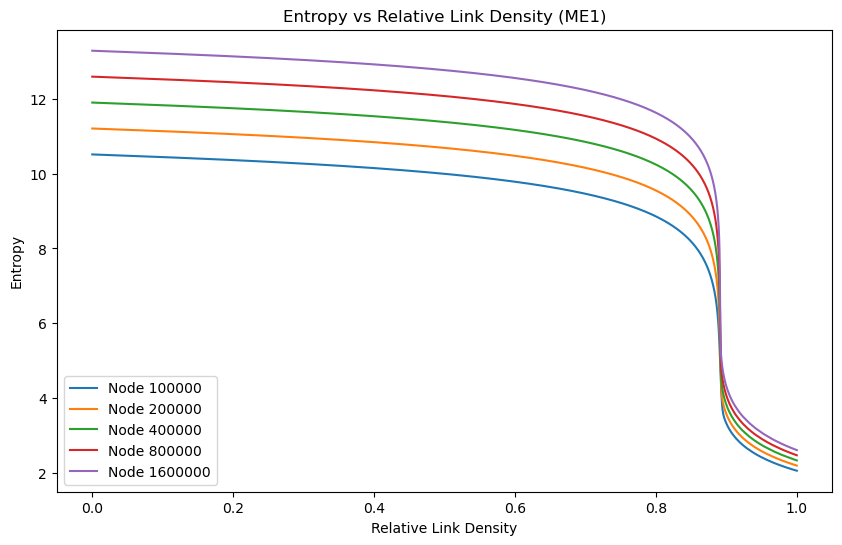

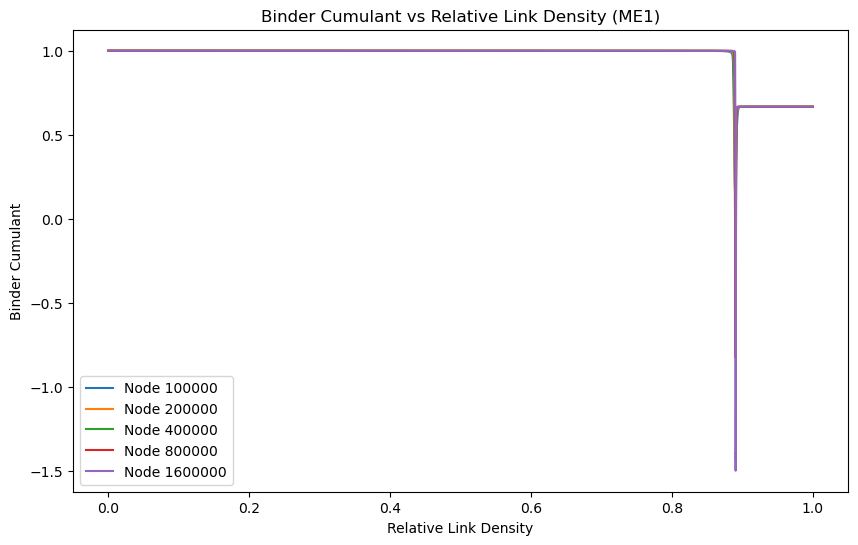

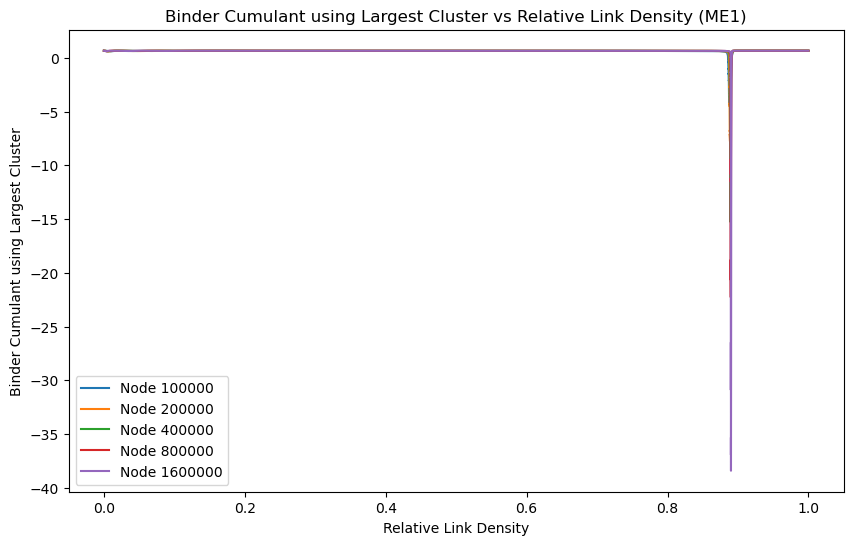

In [88]:
# Plot full scale graphs and save
# all_data for graphs in label sequence
labels = ["Entropy", "Binder Cumulant", "Binder Cumulant using Largest Cluster"]
all_data = [entropies, binder_cum_moment, binder_cum_largest_cl]

for idx, label in enumerate(labels):
    print(f"Plotting {label}")
    # Set figure size
    plt.figure(figsize=(10, 6))
    for idxx, node in enumerate(nodes):
        x = np.linspace(1/node,1,node)
        plt.plot(x, all_data[idx][idxx], label=f'Node {node}')
    
    plt.legend()
    plt.ylabel(label)
    plt.xlabel('Relative Link Density')
    plt.title(f'{label} vs Relative Link Density (ME1)')
    plt.savefig(f"explosive_percolation_me1_{label}.jpg", dpi=1000, bbox_inches="tight", transparent=False)

Plotting Binder Cumulant
Plotting Binder Cumulant using Largest Cluster


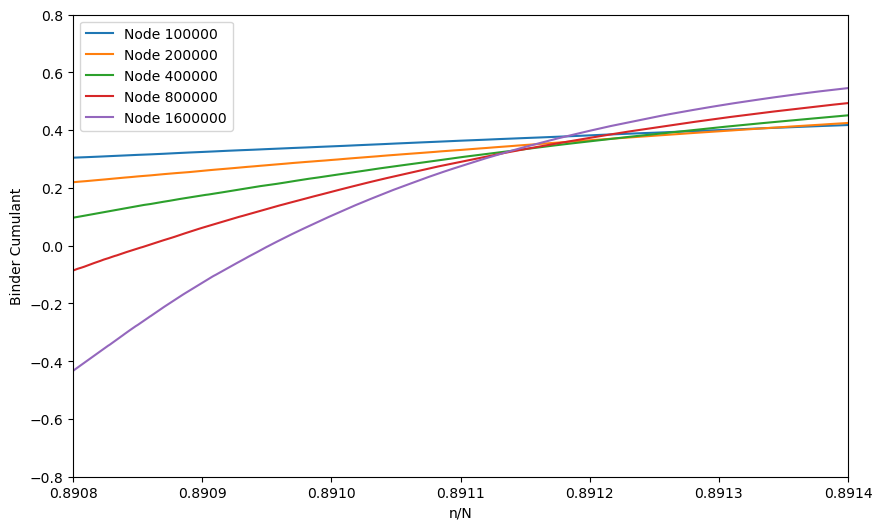

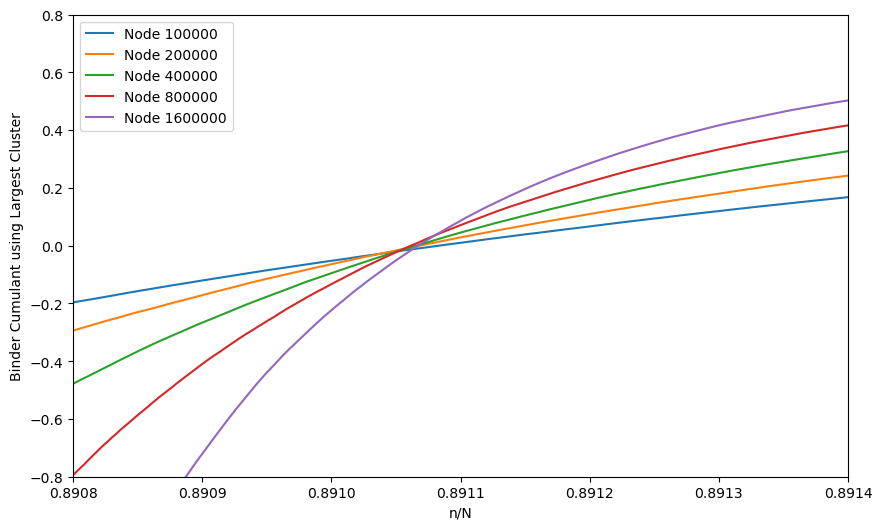

In [107]:
# Plot zoomed binder cumulant graph
labels = ["Binder Cumulant", "Binder Cumulant using Largest Cluster"]
all_data = [binder_cum_moment, binder_cum_largest_cl]
for idx, label in enumerate(labels):
    print(f"Plotting {label}")
    # Set figure size
    plt.figure(figsize=(10, 6))
    for idxx, node in enumerate(nodes):
        x = np.linspace(1/node,1,node)
        plt.plot(x, all_data[idx][idxx], label=f'Node {node}')
    
    plt.legend()
    plt.ylabel(label)
    plt.xlabel('n/N')
    plt.xlim(0.8908, 0.8914)
    plt.ylim(-0.8, 0.8)
    plt.savefig(f"explosive_percolation_me1_{label}_zoomed.jpg", dpi=1000, bbox_inches="tight", transparent=False)

Plotting Binder Cumulant


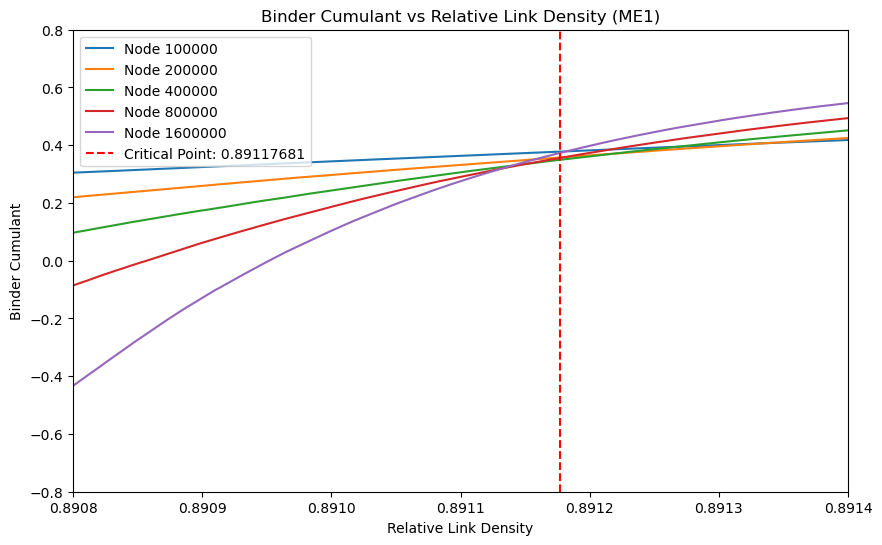

Critical point for Binder Cumulant: x = 0.89117681
Plotting Binder Cumulant using Largest Cluster


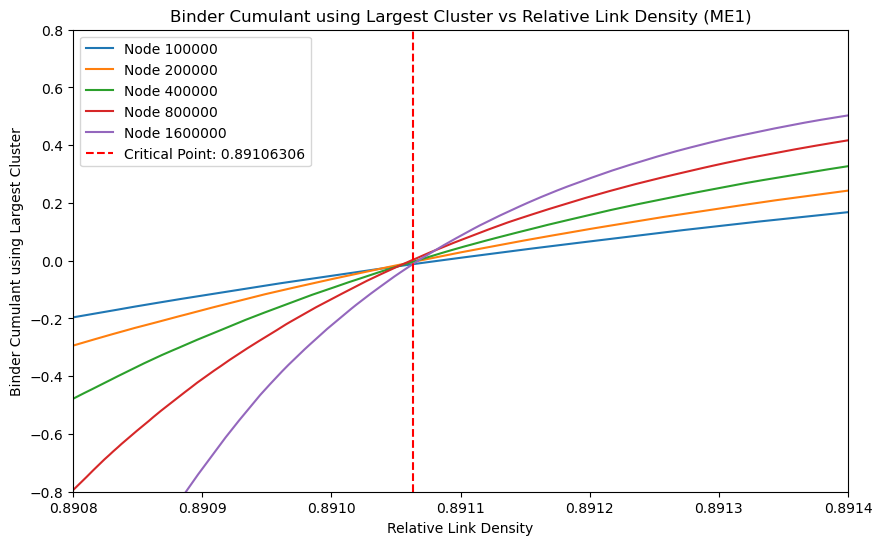

Critical point for Binder Cumulant using Largest Cluster: x = 0.89106306


In [108]:
# Function to normalize data using convolution
def normalize_data_with_convolution(y_data, node, num_points=1600000):
    """
    Normalize data to a uniform x range [0, 1] using convolution.

    Args:
    - y_data: The y-values for the given node.
    - node: The number of nodes.
    - num_points: Number of points for the uniform x range.

    Returns:
    - x_uniform: Uniform x-values between 0 and 1.
    - y_smoothed: Smoothed y-values corresponding to x_uniform.
    """
    x_local = np.linspace(1 / node, 1, node)
    x_uniform = np.linspace(0, 1, num_points)
    y_smoothed = np.interp(x_uniform, x_local, y_data)
    y_smoothed = uniform_filter1d(y_smoothed, size=5)  # Apply convolution smoothing
    return x_uniform, y_smoothed

# Function to calculate the critical point
def find_critical_point_convolved(all_data, nodes, x_range=(0.8908, 0.8912), num_points=1600000):
    """
    Find the critical point by calculating the standard deviation for each x within the range.

    Args:
    - all_data: List of y_data for all nodes.
    - nodes: List of node counts.
    - x_range: Range of x-values for standard deviation calculation (default: 0.8908, 0.8914).
    - num_points: Number of uniform points for x.

    Returns:
    - critical_x: The x-value with the minimum standard deviation within the range.
    """
    # Normalize data for all nodes
    y_values_at_x = []
    for node, y_data in zip(nodes, all_data):
        x_uniform, y_smoothed = normalize_data_with_convolution(y_data, node, num_points)
        y_values_at_x.append(y_smoothed)

    # Convert list of y-values to numpy array
    y_values_at_x = np.array(y_values_at_x)

    # Get the x-values that fall within the specified range
    range_mask = (x_uniform >= x_range[0]) & (x_uniform <= x_range[1])

    # Apply the range mask to the y-values
    y_values_in_range = y_values_at_x[:, range_mask]

    # Calculate standard deviation within the range
    std_devs = np.std(y_values_in_range, axis=0)

    # Find critical point (x value with minimum std dev)
    min_std_idx = np.argmin(std_devs)
    critical_x = x_uniform[range_mask][min_std_idx]

    return critical_x

# Main plotting process
labels = ["Binder Cumulant", "Binder Cumulant using Largest Cluster"]
all_data = [binder_cum_moment, binder_cum_largest_cl]

for idx, label in enumerate(labels):
    print(f"Plotting {label}")
    plt.figure(figsize=(10, 6))

    # Prepare data for critical point calculation
    all_y_data = all_data[idx]
    critical_x = find_critical_point_convolved(all_y_data, nodes)

    # Plot data for each node
    for idxx, node in enumerate(nodes):
        x_uniform, y_smoothed = normalize_data_with_convolution(all_data[idx][idxx], node)
        plt.plot(x_uniform, y_smoothed, label=f'Node {node}')

    # Mark the critical point with a vertical line
    plt.axvline(critical_x, color='red', linestyle='--', label=f'Critical Point: {critical_x:.8f}')

    # Finalize plot details
    plt.title(f'{label} vs Relative Link Density (ME1)')
    plt.xlabel('Relative Link Density')
    plt.ylabel(label)
    plt.xlim(0.8908, 0.8914)
    plt.ylim(-0.8, 0.8)
    plt.legend(loc='upper left')
    plt.savefig(f"explosive_percolation_me1_{label}_zoomed_with_critical_point.jpg", dpi=1000, bbox_inches="tight", transparent=False)
    plt.show()

    print(f"Critical point for {label}: x = {critical_x:.8f}")


In [13]:
def explosive_percolation_me2(num_of_nodes):
    # s_4, s_2 and s_log_s cache for the system
    global s_4_cache
    global s_2_cache
    # global s_log_s_cache
    
    # Necessary lists for percolation
    cluster_ids = np.arange(0, num_of_nodes)
    cluster_size = np.ones(num_of_nodes, dtype=np.int64) # Here Size means number of sites

    # A dictionary for members of a cluster
    # and a list of sets for directly connected nodes for each node
    cluster_members = {}
    for ids in cluster_ids:
        cluster_members[ids] = set([ids])
    connected_ids = [set([ids]) for ids in cluster_ids]

    # Output data
    # For convinience, we are taking one extra value. This will act as initial.
    # The function will return value from idx 1 to last
    # We will mainly calculate Boltzmann Entropy
    entropy = np.zeros(num_of_nodes+1, dtype=np.float64)
    entropy[0] = log_n_factorial[num_of_nodes]
    # # Shanon Entropy will be calculated for test purpose
    # entropy_shanon = np.zeros(num_of_nodes+1, dtype=np.float64)
    # entropy_shanon[0] = -s_log_s_cache[1]*num_of_nodes
    # Largest cluster size at each step
    largest_cluster_size = np.ones(num_of_nodes+1, dtype=np.int32)
    # Sum of s_i^4 at each step where s_i = size of a cluster / total size
    sum_s_4 = np.zeros(num_of_nodes+1, dtype=np.float64)
    sum_s_4[0] = s_4_cache[1]*num_of_nodes
    # Sum of s_i^2 at each step where s_i = size of a cluster / total size
    sum_s_2 = np.zeros(num_of_nodes+1, dtype=np.float64)
    sum_s_2[0] = s_2_cache[1]*num_of_nodes
    

    # Create two copies of list of nodes idx and shuffle them
    # Use the shuffled items as node 1 and node 3
    node_1s = cluster_ids.copy()
    node_1s = random.choices(node_1s, k=num_of_nodes)
    node_3s = cluster_ids.copy()
    node_3s = random.choices(node_3s, k=num_of_nodes)

    # # Test to check if shanon and boltzmann disagree
    # count = 0

    for n, node_1, node_3 in zip(range(num_of_nodes), node_1s, node_3s):
        # Randomly select 2nd node but make sure it doesn't select any node directly connected to node 1
        node_2 = random.randint(0, num_of_nodes-1)
        while node_2 in connected_ids[node_1]:
            node_2 = random.randint(0, num_of_nodes-1)

        # Randomly select 4th node but make sure it doesn't select any node directly connected to node 3
        node_4 = random.randint(0, num_of_nodes-1)
        while node_4 in connected_ids[node_3] or node_4 == node_2:
            node_4 = random.randint(0, num_of_nodes-1)

        # Get the cluster ids
        cluster_1 = cluster_ids[node_1]
        cluster_2 = cluster_ids[node_2]
        cluster_3 = cluster_ids[node_3]
        cluster_4 = cluster_ids[node_4]

        # Get the cluster sizes
        cluster_1_size = cluster_size[cluster_1]
        cluster_2_size = cluster_size[cluster_2]
        cluster_3_size = cluster_size[cluster_3]
        cluster_4_size = cluster_size[cluster_4]

        # If any bond is intra-cluster, add these two bonds
        # Check if the bonds are intra-cluster
        is_12_intra = cluster_1 == cluster_2
        is_34_intra = cluster_3 == cluster_4

        # Comparing Entropies
        del_s_12 = abs(log_n_factorial[cluster_1_size] + log_n_factorial[cluster_2_size] - log_n_factorial[cluster_1_size+cluster_2_size])
        del_s_34 = abs(log_n_factorial[cluster_3_size] + log_n_factorial[cluster_4_size] - log_n_factorial[cluster_3_size+cluster_4_size])

        # # Comparing shanon entropies
        # del_s_12_shanon = abs(s_log_s_cache[cluster_1_size] + s_log_s_cache[cluster_2_size] - s_log_s_cache[cluster_1_size+cluster_2_size])
        # del_s_34_shanon = abs(s_log_s_cache[cluster_3_size] + s_log_s_cache[cluster_4_size] - s_log_s_cache[cluster_3_size+cluster_4_size])

        # # Check if shanon and boltzmann disagree for small N
        # if (del_s_12 < del_s_34) != (del_s_12_shanon < del_s_34_shanon):
        #     count += 1

        # If del_s_12 is less than del_s_34, add the link between 1 and 2 and update the parameters
        if del_s_12 < del_s_34:
            entropy_change = del_s_12
            # shanon_entropy_change = del_s_12_shanon

            # If any one bond is intra-cluster, add the bond
            if is_12_intra:
                # Update directly connected id list
                connected_ids[node_1].add(node_2)
                connected_ids[node_2].add(node_1)
                # Update Entropy
                entropy[n+1] = entropy[n]
                # # Update Shanon Entropy
                # entropy_shanon[n+1] = entropy_shanon[n]
                # Update largest cluster
                largest_cluster_size[n+1] = largest_cluster_size[n]
                # Update s^4
                sum_s_4[n+1] = sum_s_4[n]
                # Update s^2
                sum_s_2[n+1] = sum_s_2[n]

                continue

            # Select the larger cluster as parent
            if cluster_2_size < cluster_1_size:
                parent_id = node_1
                parent_cluster_size = cluster_1_size
                parent_cluster_id = cluster_1
                child_id = node_2
                child_cluster_size = cluster_2_size
                child_cluster_id = cluster_2
            else:
                parent_id = node_2
                parent_cluster_size = cluster_2_size
                parent_cluster_id = cluster_2
                child_id = node_1
                child_cluster_size = cluster_1_size
                child_cluster_id = cluster_1

        else:
            entropy_change = del_s_34
            # shanon_entropy_change = del_s_34_shanon

            if is_34_intra:
                # Update directly connected id list
                connected_ids[node_3].add(node_4)
                connected_ids[node_4].add(node_3)
                # Update Entropy
                entropy[n+1] = entropy[n]
                # # Update Shanon Entropy
                # entropy_shanon[n+1] = entropy_shanon[n]
                # Update largest cluster
                largest_cluster_size[n+1] = largest_cluster_size[n]
                # Update s^4
                sum_s_4[n+1] = sum_s_4[n]
                # Update s^2
                sum_s_2[n+1] = sum_s_2[n]

                continue

            # Select the larger cluster as parent
            if cluster_4_size < cluster_3_size:
                parent_id = node_3
                parent_cluster_size = cluster_3_size
                parent_cluster_id = cluster_3
                child_id = node_4
                child_cluster_size = cluster_4_size
                child_cluster_id = cluster_4
            else:
                parent_id = node_4
                parent_cluster_size = cluster_4_size
                parent_cluster_id = cluster_4
                child_id = node_3
                child_cluster_size = cluster_3_size
                child_cluster_id = cluster_3

        # Update cluster_size
        cluster_size[parent_cluster_id] = parent_cluster_size + child_cluster_size
        # Reset the child cluster size to zero indicating it doesn't exists
        cluster_size[child_cluster_id] = 0

        # For all sites of the child cluster, update their cluster id as the parent cluster id
        child_cluster_members = list(cluster_members[child_cluster_id])
        cluster_members[parent_cluster_id].update(child_cluster_members)
        cluster_ids[child_cluster_members] = parent_cluster_id
        # Delete the child cluster member
        del cluster_members[child_cluster_id]

        # Update directly connected id list
        connected_ids[parent_id].add(child_id)
        connected_ids[child_id].add(parent_id)

        # Update Entropy
        entropy[n+1] = entropy[n] - entropy_change
        # # Update Shanon Entropy
        # entropy_shanon[n+1]= entropy_shanon[n] - shanon_entropy_change
        # Update largest cluster
        # It is the size of the new cluster if it is larger than the previous largest cluster value
        # Since we have updated the cluster_size[parent_cluster_id], it contains the totals size
        # but parent_cluster_size contains the previous cluster size
        largest_cluster_size[n+1] = max(largest_cluster_size[n], cluster_size[parent_cluster_id])
        # Update s^4
        # del_s_4 = (s_i + s_j)^4 - s_i^4 - s_j^4
        sum_s_4[n+1] = sum_s_4[n] + s_4_cache[cluster_size[parent_cluster_id]] - s_4_cache[parent_cluster_size] - s_4_cache[child_cluster_size]
        # Update s^2
        # del_s_2 = (s_i + s_j)^2 - s_i^2 - s_j^2
        sum_s_2[n+1] = sum_s_2[n] + s_2_cache[cluster_size[parent_cluster_id]] - s_2_cache[parent_cluster_size] - s_2_cache[child_cluster_size]
        
    # # Print num of times shanon disagree boltzmann
    # print(f"Shanon and Boltzmann disagree {count} times")

    # Since Boltzmann Entropy is extrinsic, we calculate H = S/N
    entropy = entropy/num_of_nodes
    # return np.array([entropy[1:], binder_cum])
    return entropy[1:], np.power(largest_cluster_size[1:]/num_of_nodes, 4), np.power(largest_cluster_size[1:]/num_of_nodes, 2), sum_s_4[1:], sum_s_2[1:]


In [14]:
def parallel_explosive_percolation_me2(num_of_nodes, n, m=1000):
    try:
        # Load existing data if available
        with open(f"explosive_perco_me2_entropy_largest_cluster_4_2_sum_s_4_2_{num_of_nodes}.pkl", 'rb') as f:
            s_and_m = pickle.load(f)
    except FileNotFoundError:
        # Initialize structure to store results if no data exists
        s_and_m = {
            'count': 0,
            'entropy': np.zeros(num_of_nodes),
            'largest_cluster_size_4': np.zeros(num_of_nodes),
            'largest_cluster_size_2': np.zeros(num_of_nodes),
            'sum_s_4': np.zeros(num_of_nodes),
            'sum_s_2': np.zeros(num_of_nodes)
        }

    # Split n into chunks of size m
    chunks = (n + m - 1) // m  # Calculate the number of chunks

    # Initialize accumulators for all quantities
    entropy_sum_local = np.zeros(num_of_nodes)
    # shannon_entropy_sum_local = np.zeros(num_of_nodes)
    largest_cluster_size_4_sum_local = np.zeros(num_of_nodes)
    largest_cluster_size_2_sum_local = np.zeros(num_of_nodes)
    sum_s_4_local = np.zeros(num_of_nodes)
    sum_s_2_local = np.zeros(num_of_nodes)

    for chunk in range(chunks):
        current_m = min(m, n - chunk * m)  # Handle the last chunk which may be smaller

        # Using ProcessPoolExecutor to parallelize the task execution
        with ProcessPoolExecutor() as executor:
            # Submit `current_m` percolation tasks to the executor
            futures = [executor.submit(explosive_percolation_me2, num_of_nodes) for _ in range(current_m)]

            # Reset accumulators for the current chunk
            entropy_sum_local.fill(0)
            # shannon_entropy_sum_local.fill(0)
            largest_cluster_size_4_sum_local.fill(0)
            largest_cluster_size_2_sum_local.fill(0)
            sum_s_4_local.fill(0)
            sum_s_2_local.fill(0)

            # Inner loop with tqdm to track progress of percolation tasks
            for future in tqdm(as_completed(futures), total=current_m, desc=f"Processing chunk {chunk + 1}/{chunks}", leave=False, disable=False):
                result = future.result()  # Assuming `result` is a list of NumPy arrays

                # Extract components from result
                entropy, largest_cluster_size_4, largest_cluster_size_2, sum_s_4, sum_s_2 = result

                # Aggregate results from this task
                entropy_sum_local += entropy
                # shannon_entropy_sum_local += shannon_entropy
                largest_cluster_size_4_sum_local += largest_cluster_size_4
                largest_cluster_size_2_sum_local += largest_cluster_size_2
                sum_s_4_local += sum_s_4
                sum_s_2_local += sum_s_2

            # Consistently update global accumulators
            s_and_m['entropy'] += entropy_sum_local
            # s_and_m['shannon_entropy'] += shannon_entropy_sum_local
            s_and_m['largest_cluster_size_4'] += largest_cluster_size_4_sum_local
            s_and_m['largest_cluster_size_2'] += largest_cluster_size_2_sum_local
            s_and_m['sum_s_4'] += sum_s_4_local
            s_and_m['sum_s_2'] += sum_s_2_local

            # Update count
            s_and_m['count'] += current_m

        # Save updated data after each chunk
        pkl_path = f"explosive_perco_me2_entropy_largest_cluster_4_2_sum_s_4_2_{num_of_nodes}.pkl"
        with open(pkl_path, 'wb') as f:
            pickle.dump(s_and_m, f)

        # Free up memory after processing each chunk
        del futures
        gc.collect()  # Force garbage collection

    return s_and_m


In [17]:
num_of_nodes = 1600000
ensembles = 91000
# s_4, s_2 and s_log_s cache for the system
s_4_cache = s_4[2*num_of_nodes]
s_2_cache = s_2[2*num_of_nodes]
# s_log_s_cache = s_log_s[num_of_nodes]

_ = parallel_explosive_percolation_me2(num_of_nodes, ensembles, m=500)

In [18]:
#Test ensemble size
nodes = [100000, 200000, 400000, 800000, 1600000]

for node in nodes:
    try:
        with open(f"explosive_perco_me2_entropy_largest_cluster_4_2_sum_s_4_2_{node}.pkl", 'rb') as f:
            data_ = pickle.load(f)
            print(f"Ensemble of {node} is {data_['count']}")

    except FileNotFoundError:
        print(f"Ensemble of {node} is 0")

del data_
gc.collect()

Ensemble of 100000 is 102000
Ensemble of 200000 is 100000
Ensemble of 400000 is 100000
Ensemble of 800000 is 100000
Ensemble of 1600000 is 100000


0

In [100]:
# Import pickle data
nodes = [100000, 200000, 400000, 800000, 1600000]

data_f = []
for node in nodes:
    with open(f"explosive_perco_me2_entropy_largest_cluster_4_2_sum_s_4_2_{node}.pkl", 'rb') as f:
        data_f.append(pickle.load(f))

# Calculate ensemble averages
entropies_me2 = [data_f[idx]["entropy"]/data_f[idx]["count"] for idx in range(len(nodes))]
# shannon_entropies = [data_f[idx]["shannon_entropy"]/data_f[idx]["count"] for idx in range(len(nodes))]

largest_clusters_4_me2 = [data_f[idx]["largest_cluster_size_4"]/data_f[idx]["count"] for idx in range(len(nodes))]
largest_clusters_2_me2 = [3*np.power(data_f[idx]["largest_cluster_size_2"]/data_f[idx]["count"], 2) for idx in range(len(nodes))]

s_4_sum_me2 = [data_f[idx]["sum_s_4"]/data_f[idx]["count"] for idx in range(len(nodes))]
# Calculate 3*avg(s_2)^2
s_2_sum_me2 = [3*np.power(data_f[idx]["sum_s_2"]/data_f[idx]["count"], 2) for idx in range(len(nodes))]

# Calculate largest_clusters
# binder_cum_largest_cl = [0 for _ in nodes]
binder_cum_moment_me2 = [1 - s_4_sum_me2[idx]/s_2_sum_me2[idx] for idx in range(len(nodes))]
binder_cum_largest_cl_me2 = [1 - largest_clusters_4_me2[idx]/largest_clusters_2_me2[idx] for idx in range(len(nodes))]

Plotting Entropy
Plotting Binder Cumulant
Plotting Binder Cumulant using Largest Cluster


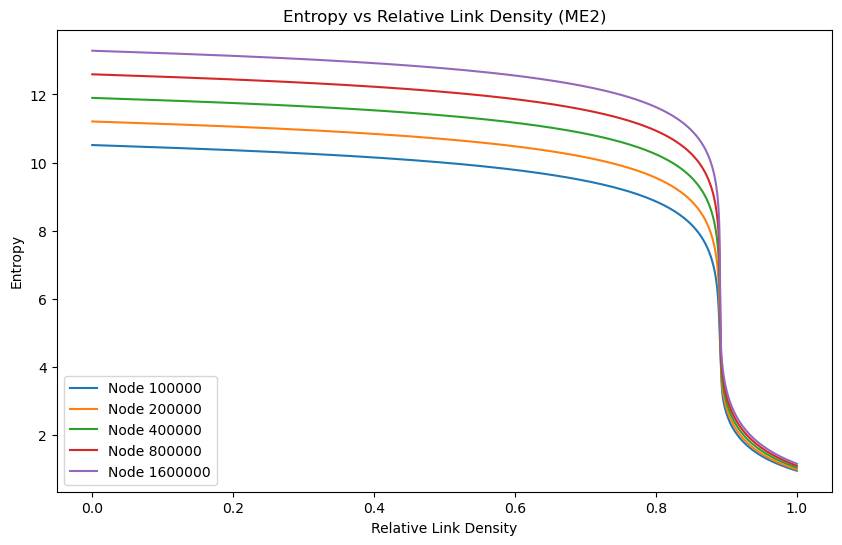

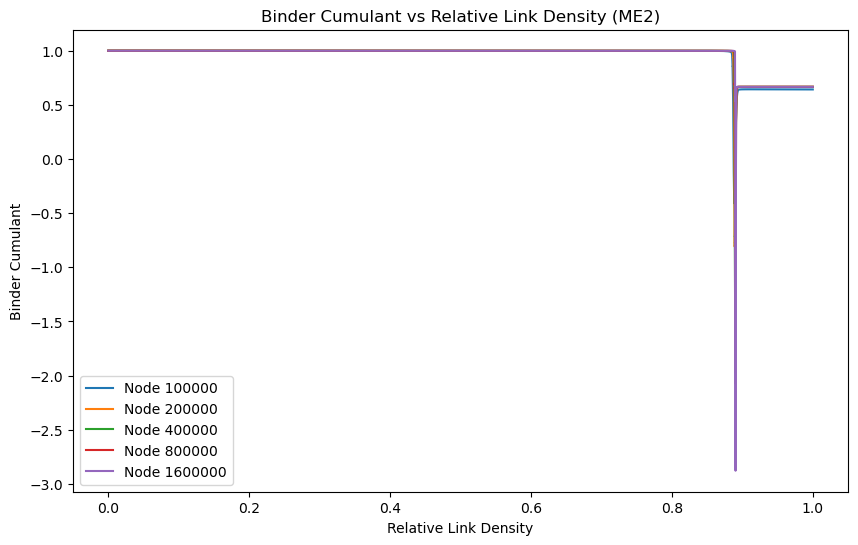

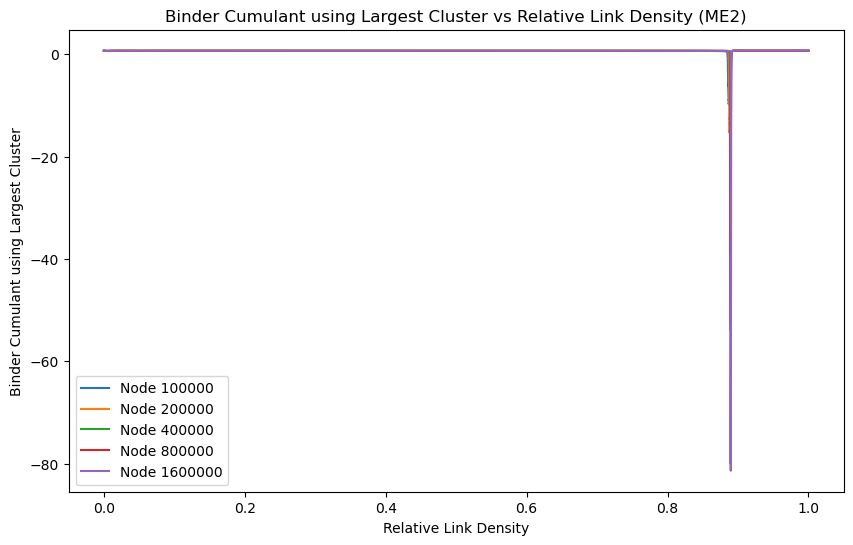

In [74]:
# Plot full scale graphs and save
# all_data for graphs in label sequence
labels = ["Entropy", "Binder Cumulant", "Binder Cumulant using Largest Cluster"]
all_data_me2 = [entropies_me2, binder_cum_moment_me2, binder_cum_largest_cl_me2]

for idx, label in enumerate(labels):
    print(f"Plotting {label}")
    # Set figure size
    plt.figure(figsize=(10, 6))
    for idxx, node in enumerate(nodes):
        x = np.linspace(1/node,1,node)
        plt.plot(x, all_data_me2[idx][idxx], label=f'Node {node}')
    
    plt.legend()
    plt.ylabel(label)
    plt.xlabel('Relative Link Density')
    plt.title(f'{label} vs Relative Link Density (ME2)')
    plt.savefig(f"explosive_percolation_me2_{label}.jpg", dpi=1000, bbox_inches="tight", transparent=False)

Plotting Binder Cumulant
Plotting Binder Cumulant using Largest Cluster


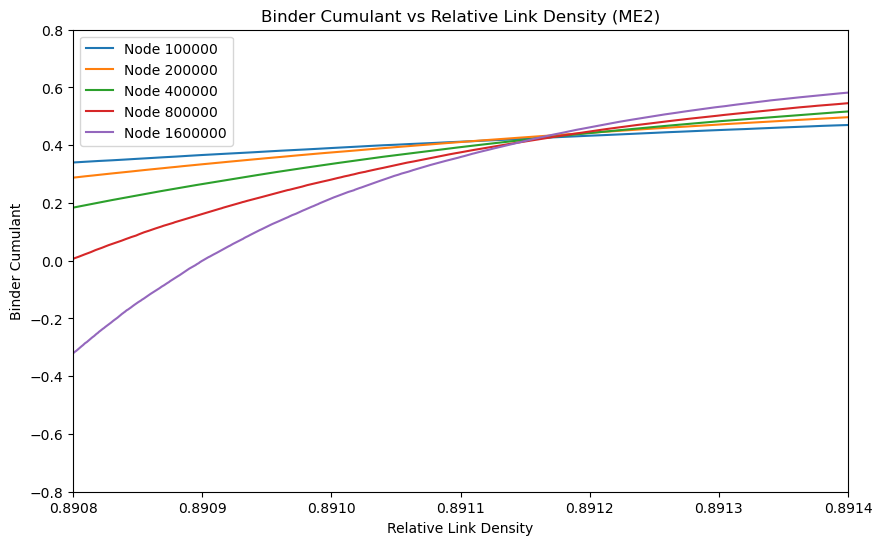

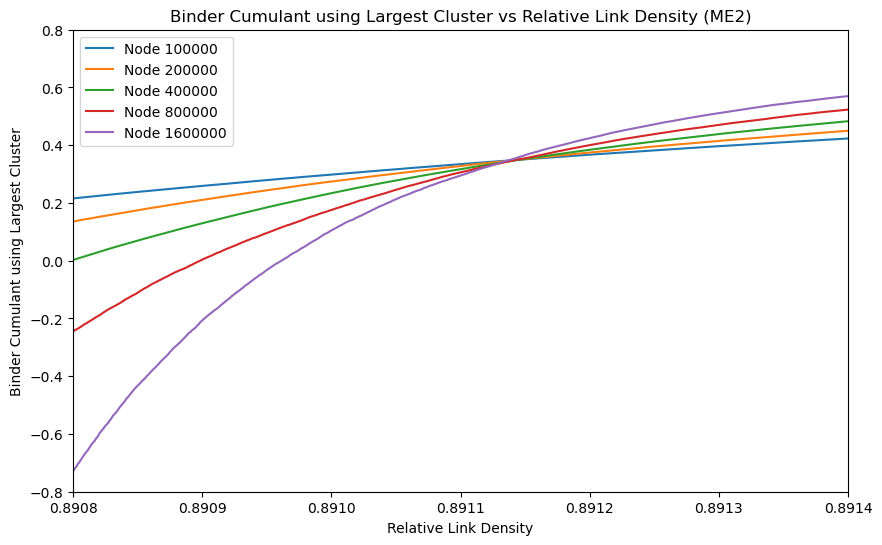

In [101]:
# Plot zoomed binder cumulant graph
labels = ["Binder Cumulant", "Binder Cumulant using Largest Cluster"]
all_data_me2 = [binder_cum_moment_me2, binder_cum_largest_cl_me2]
for idx, label in enumerate(labels):
    print(f"Plotting {label}")
    # Set figure size
    plt.figure(figsize=(10, 6))
    for idxx, node in enumerate(nodes):
        x = np.linspace(1/node,1,node)
        plt.plot(x, all_data_me2[idx][idxx], label=f'Node {node}')
    
    plt.legend()
    plt.ylabel(label)
    plt.xlabel('Relative Link Density')
    plt.title(f'{label} vs Relative Link Density (ME2)')
    plt.xlim(0.8908, 0.8914)
    plt.ylim(-0.8, 0.8)
    plt.savefig(f"explosive_percolation_me2_{label}_zoomed.jpg", dpi=1000, bbox_inches="tight", transparent=False)

Plotting Binder Cumulant


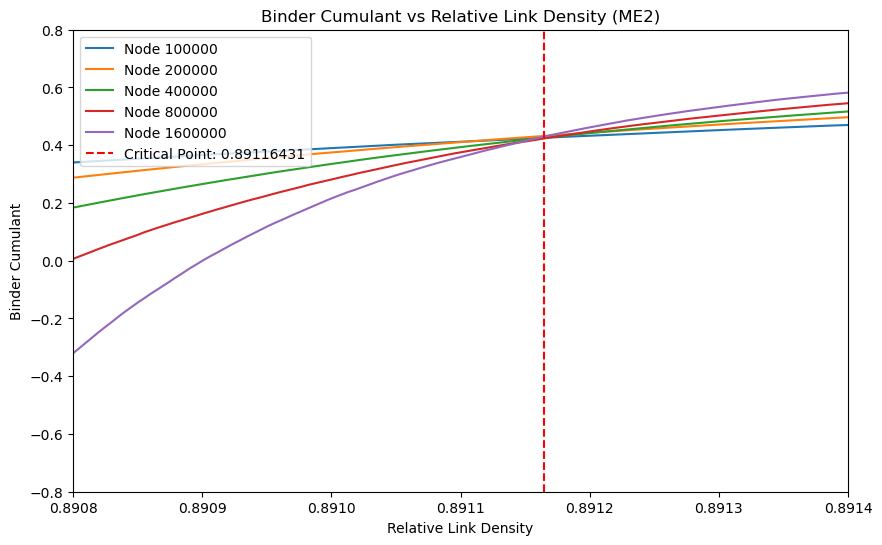

Critical point for Binder Cumulant: x = 0.89116431
Plotting Binder Cumulant using Largest Cluster


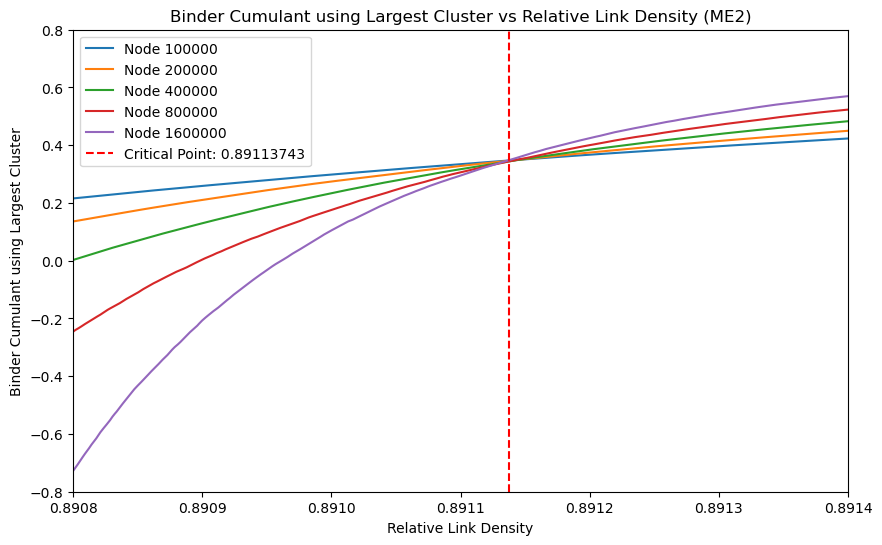

Critical point for Binder Cumulant using Largest Cluster: x = 0.89113743


In [102]:
# Function to normalize data using convolution
def normalize_data_with_convolution(y_data, node, num_points=1600000):
    """
    Normalize data to a uniform x range [0, 1] using convolution.

    Args:
    - y_data: The y-values for the given node.
    - node: The number of nodes.
    - num_points: Number of points for the uniform x range.

    Returns:
    - x_uniform: Uniform x-values between 0 and 1.
    - y_smoothed: Smoothed y-values corresponding to x_uniform.
    """
    x_local = np.linspace(1 / node, 1, node)
    x_uniform = np.linspace(0, 1, num_points)
    y_smoothed = np.interp(x_uniform, x_local, y_data)
    y_smoothed = uniform_filter1d(y_smoothed, size=5)  # Apply convolution smoothing
    return x_uniform, y_smoothed

# Function to calculate the critical point
def find_critical_point_convolved(all_data, nodes, x_range=(0.8908, 0.8912), num_points=1600000):
    """
    Find the critical point by calculating the standard deviation for each x within the range.

    Args:
    - all_data: List of y_data for all nodes.
    - nodes: List of node counts.
    - x_range: Range of x-values for standard deviation calculation (default: 0.8908, 0.8914).
    - num_points: Number of uniform points for x.

    Returns:
    - critical_x: The x-value with the minimum standard deviation within the range.
    """
    # Normalize data for all nodes
    y_values_at_x = []
    for node, y_data in zip(nodes, all_data):
        x_uniform, y_smoothed = normalize_data_with_convolution(y_data, node, num_points)
        y_values_at_x.append(y_smoothed)

    # Convert list of y-values to numpy array
    y_values_at_x = np.array(y_values_at_x)

    # Get the x-values that fall within the specified range
    range_mask = (x_uniform >= x_range[0]) & (x_uniform <= x_range[1])

    # Apply the range mask to the y-values
    y_values_in_range = y_values_at_x[:, range_mask]

    # Calculate standard deviation within the range
    std_devs = np.std(y_values_in_range, axis=0)

    # Find critical point (x value with minimum std dev)
    min_std_idx = np.argmin(std_devs)
    critical_x = x_uniform[range_mask][min_std_idx]

    return critical_x

# Main plotting process
labels = ["Binder Cumulant", "Binder Cumulant using Largest Cluster"]
all_data_me2 = [binder_cum_moment_me2, binder_cum_largest_cl_me2]

for idx, label in enumerate(labels):
    print(f"Plotting {label}")
    plt.figure(figsize=(10, 6))

    # Prepare data for critical point calculation
    all_y_data = all_data_me2[idx]
    critical_x = find_critical_point_convolved(all_y_data, nodes)

    # Plot data for each node
    for idxx, node in enumerate(nodes):
        x_uniform, y_smoothed = normalize_data_with_convolution(all_data_me2[idx][idxx], node)
        plt.plot(x_uniform, y_smoothed, label=f'Node {node}')

    # Mark the critical point with a vertical line
    plt.axvline(critical_x, color='red', linestyle='--', label=f'Critical Point: {critical_x:.8f}')

    # Finalize plot details
    plt.title(f'{label} vs Relative Link Density (ME2)')
    plt.xlabel('Relative Link Density')
    plt.ylabel(label)
    plt.xlim(0.8908, 0.8914)
    plt.ylim(-0.8, 0.8)
    plt.legend(loc='upper left')
    plt.savefig(f"explosive_percolation_me2_{label}_zoomed_with_critical_point.jpg", dpi=1000, bbox_inches="tight", transparent=False)
    plt.show()

    print(f"Critical point for {label}: x = {critical_x:.8f}")
